In [2]:
import pandas as pd
import psycopg2 as pg
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import seaborn as sns
import random
from model_evaluation import *
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score,
                             precision_score, recall_score, roc_auc_score, roc_curve, auc,
                             precision_recall_curve)
import pickle

In [3]:
connection_args = {
    'host': 'euw-postgres.onitsoft.com',
    'dbname': 'bot_detector',
    'port': 5432,
    'user': 'postgres',
    'password': 'Os5ef.7Q{8j!?7R'
}

connection = pg.connect(**connection_args)  

In [4]:
bots_df = pd.read_sql(f'SELECT * FROM users where bot = true limit 200000', connection)
humans_df = pd.read_sql(f'SELECT * FROM users where bot = false limit 200000', connection)
raw_df = pd.concat([bots_df, humans_df])
raw_df["account_age_days"] = (datetime(year=2022, month=5, day=15, tzinfo=timezone.utc) - raw_df["created_at"]).apply(lambda d: d.days)
raw_df["average_tweets_per_day"] = raw_df["tweet_count"] / raw_df["account_age_days"]
raw_df.drop(columns=['id', 'location'], inplace=True)
raw_df['default_profile_image'] = raw_df['default_profile_image'].astype(int)
raw_df['pinned_tweet'] = raw_df['pinned_tweet'].astype(int)
raw_df['protected'] = raw_df['protected'].astype(int)
raw_df['geo_enabled'] = raw_df['geo_enabled'].astype(int)
raw_df['verified'] = raw_df['verified'].astype(int)
raw_df['created_at'] = pd.to_datetime(raw_df['created_at'])
raw_df['hour_created'] = pd.to_datetime(raw_df['created_at']).dt.hour
raw_df['bot'] = raw_df['bot'].astype(int)
df = raw_df[['bot', 'hour_created', 'verified', 'geo_enabled', 'default_profile_image', 'following_count', 'follower_count', 'listed_count', 'pinned_tweet', 'protected', 'description_urls_count', 'description_mentions_count', 'account_age_days', 'average_tweets_per_day']]
df['avg_daily_followers'] = np.round(df['follower_count'] / df['account_age_days'])
df['avg_daily_friends'] = np.round(df['follower_count'] / df['account_age_days'])
df['avg_daily_favorites'] = np.round(df['follower_count'] / df['account_age_days'])
df['following_log'] = np.round(np.log(1 + df['following_count']), 3)
df['follower_log'] = np.round(np.log(1 + df['follower_count']), 3)
df['avg_daily_tweets_log'] = np.round(np.log(1+ df['average_tweets_per_day']), 3)
df['network'] = np.round(df['following_log'] * df['follower_log'], 3)
df['tweet_to_followers'] = np.round(np.log( 1+ df['listed_count']) * np.log(1+ df['follower_count']), 3)
df['follower_acq_rate'] = np.round(np.log(1 + (df['follower_count'] / df['account_age_days'])), 3)
df['friends_acq_rate'] = np.round(np.log(1 + (df['following_count'] / df['account_age_days'])), 3)
df['favs_rate'] = np.round(np.log(1 + (df['following_count'] / df['account_age_days'])), 3)

def generate_test_data(features, records=1000):
    X = df[features]
    y = df['bot']
    state = random.randint(1, 200)
    random_indices = df.sample(n=records, random_state=state).index
    X_test = X.loc[random_indices]
    y_test = y.loc[random_indices]
    return X_test, y_test

/tmp/ipykernel_757584/460242504.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bots_df = pd.read_sql(f'SELECT * FROM users where bot = true limit 200000', connection)
/tmp/ipykernel_757584/460242504.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  humans_df = pd.read_sql(f'SELECT * FROM users where bot = false limit 200000', connection)
/tmp/ipykernel_757584/460242504.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['avg_da

In [5]:
# features_a = ['verified',
#             'geo_enabled', 
#             'protected',
#             'pinned_tweet',
#             'default_profile_image', 
#             'follower_count', 
#             'following_count', 
#             'listed_count', 
#             'average_tweets_per_day',
#             'network', 
#             'tweet_to_followers', 
#             'follower_acq_rate', 
#             'friends_acq_rate',
#             'favs_rate',
#             'hour_created',
#         ]
# features_b = ['verified',
#             'geo_enabled', 
#             'protected',
#             'pinned_tweet',
#             'default_profile_image', 
#             'follower_count', 
#             'following_count', 
#             'listed_count', 
#             'average_tweets_per_day',
#             'network', 
#             'tweet_to_followers', 
#             'follower_acq_rate', 
#             'friends_acq_rate',
#             'favs_rate',
#             'hour_created',
#         ]


features = ['verified',
            'geo_enabled',
            'protected',
            'pinned_tweet',
            'default_profile_image', 
            'follower_count', 
            'following_count', 
            'listed_count', 
            'average_tweets_per_day',
            'network', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate',
            'favs_rate',
            'hour_created',
        ]

with open("../models/app_detection/xgb_model_5a.pkl", 'rb') as f:
    model = pickle.load(f)

Po przeanalizowaniu kilku kombinacji zmiennych, które mogły mieć znaczenie dla modelu, wybrałem następujące zmienne: 'verified', 'geo_enabled', 'protected', 'pinned_tweet', 'default_profile_image', 'follower_count', 'following_count', 'average_tweets_per_day', 'network', 'tweet_to_followers', 'follower_acq_rate', 'friends_acq_rate', 'favs_rate'. Przy ich pomocy oraz hiperparametrów wybranych dla klasyfikatora XGB, udało się uzyskać model z następującymi parametrami:

In [6]:
acc_scores = []
prec_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

for i in range(10):
    X_test, y_test = generate_test_data(features, records=20000)

    pred = model.predict(X_test)

    acc_scores.append(accuracy_score(y_test, pred))
    prec_scores.append(precision_score(y_test, pred))
    recall_scores.append(recall_score(y_test, pred))
    f1_scores.append(f1_score(y_test, pred))
    roc_auc_scores.append(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

print(f'Accuracy:  {np.mean(acc_scores):.5f} +- {np.std(acc_scores):5f}')
print(f'Precision: {np.mean(prec_scores):.5f} +- {np.std(prec_scores):5f}')
print(f'Recall:    {np.mean(recall_scores):.5f} +- {np.std(recall_scores):5f}')
print(f'F1 Score:  {np.mean(f1_scores):.5f} +- {np.std(f1_scores):5f}')
print(f'ROC AUC:   {np.mean(roc_auc_scores):.5f} +- {np.std(roc_auc_scores):5f}')

Accuracy:  0.80805 +- 0.001936
Precision: 0.77351 +- 0.001691
Recall:    0.81237 +- 0.003189
F1 Score:  0.79246 +- 0.002211
ROC AUC:   0.88867 +- 0.001516


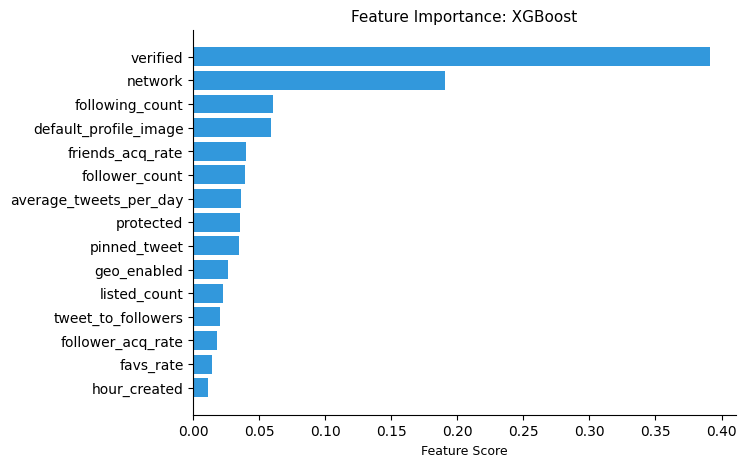

In [5]:
plot_feature_importance(model, features, model_alias='XGBoost')